# Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import plotly.express as px
import missingno as msno

# Load Data

In [126]:
train_clean = pd.read_json('../datasets/train.json')
test_df = pd.read_json('../datasets/test.json')

#### train data : 14,271 rows x 23 columns including `price`

#### test data : 2,500 rows x 22 columns w/o `price`

# Clean data & EDA

In [100]:
train_df.columns

Index(['id', 'province', 'district', 'subdistrict', 'address', 'property_type',
       'total_units', 'bedrooms', 'baths', 'floor_area', 'floor_level',
       'land_area', 'latitude', 'longitude', 'nearby_stations',
       'nearby_station_distance', 'nearby_bus_stops', 'nearby_supermarkets',
       'nearby_shops', 'year_built', 'month_built', 'facilities', 'price'],
      dtype='object')

In [8]:
# Copy DataFrame. Easier to modify and keep the original
train_clean = train_df.copy()

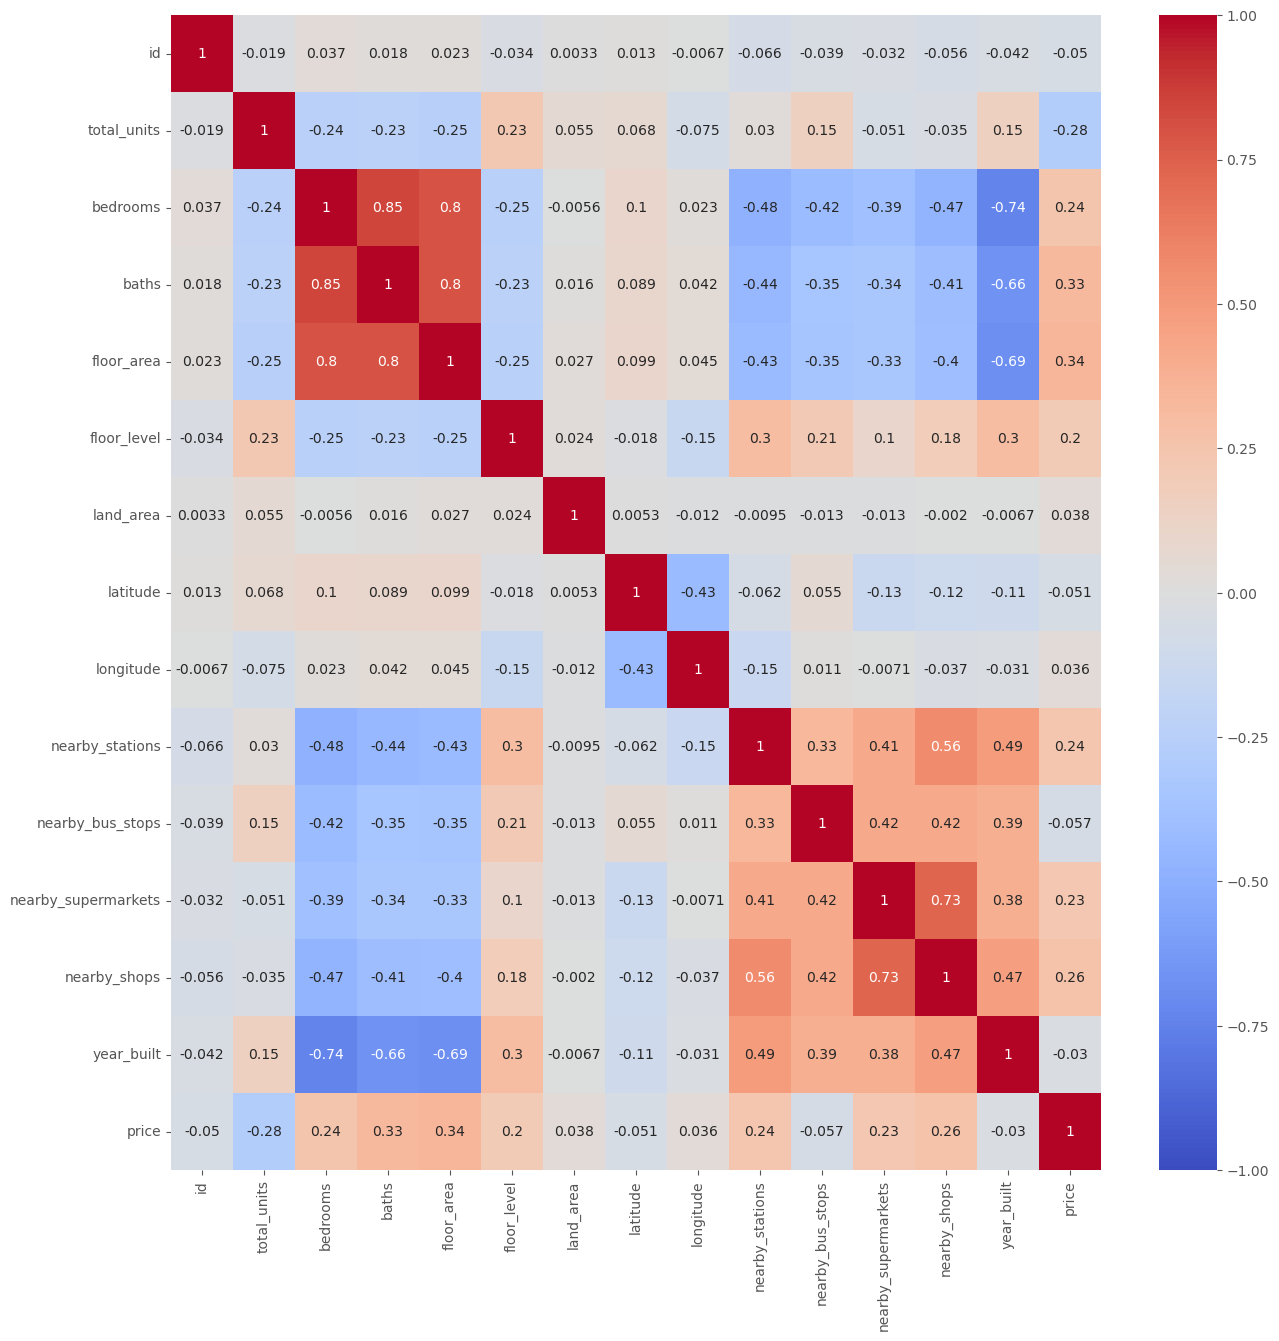

In [9]:
# Check correlation
plt.figure(figsize=(15,15))
sns.heatmap(train_clean.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap='coolwarm');

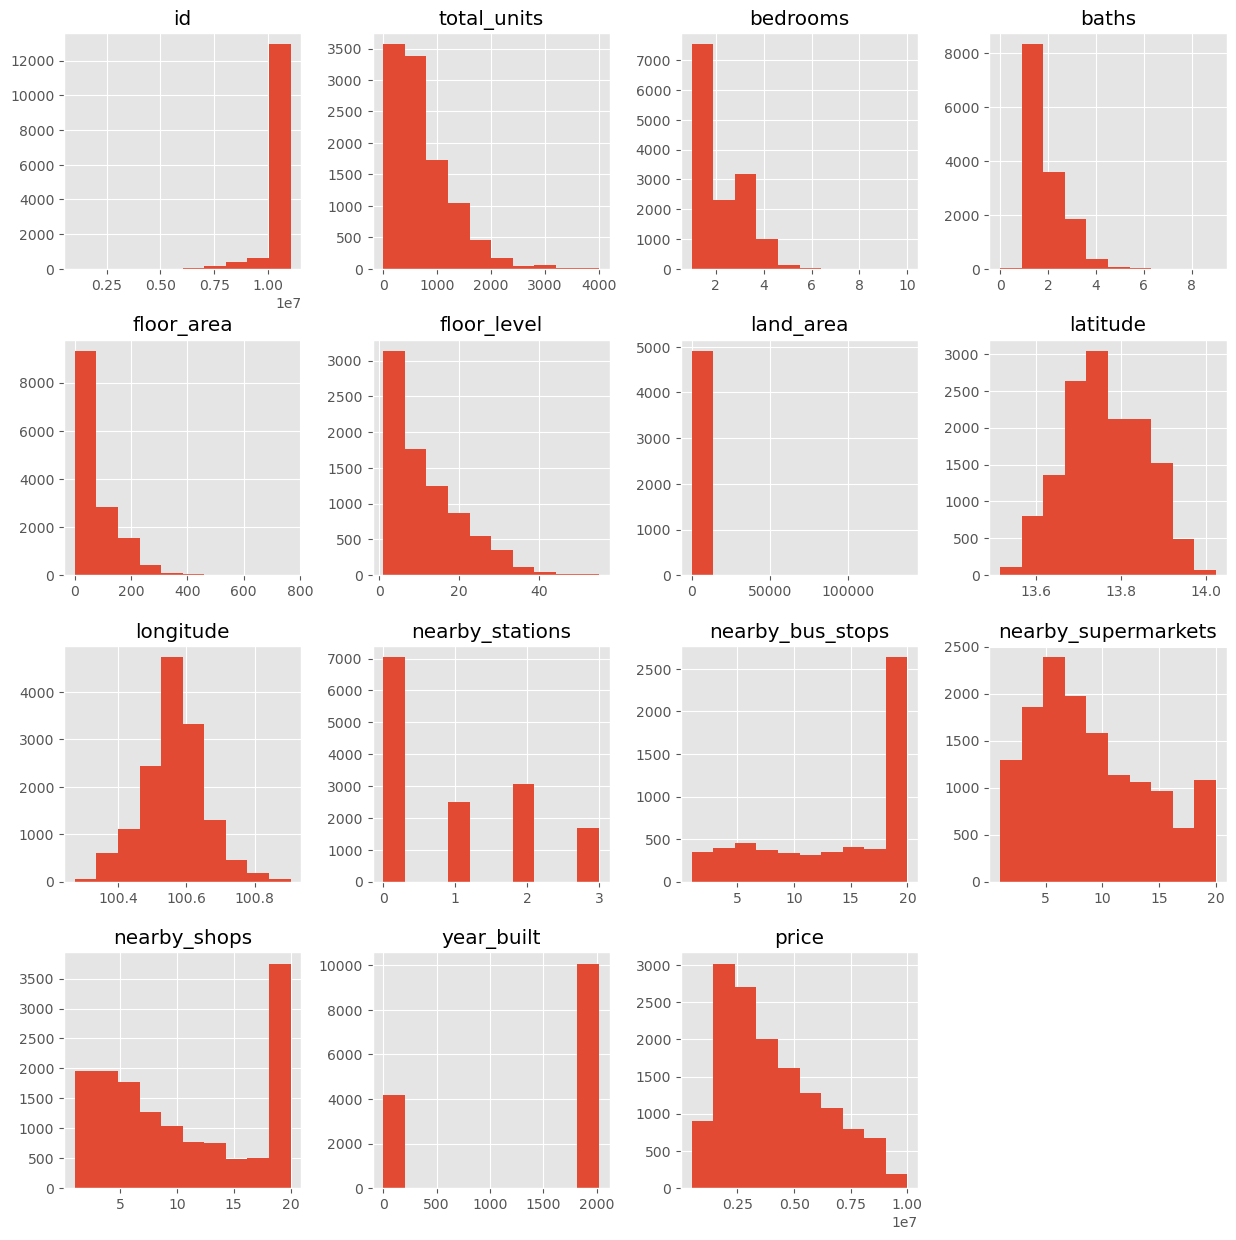

In [10]:
# Check each feature distribution
train_clean.hist(figsize=(15,15));

In [11]:
# Display data types and null counts together
print(train_clean.dtypes.to_frame(name='Data Type').join(train_clean.isna().mean().mul(100).round(2)
                                                         .rename('Null Count')).sort_values(by='Null Count', ascending=False))

                        Data Type  Null Count
land_area                 float64       65.55
nearby_bus_stops          float64       57.89
nearby_station_distance    object       49.35
floor_level               float64       43.29
month_built                object       41.16
total_units               float64       26.36
nearby_supermarkets       float64        2.70
bedrooms                  float64        0.30
baths                     float64        0.25
subdistrict                object        0.08
nearby_stations             int64        0.00
facilities                 object        0.00
year_built                  int64        0.00
nearby_shops                int64        0.00
id                          int64        0.00
longitude                 float64        0.00
latitude                  float64        0.00
province                   object        0.00
floor_area                  int64        0.00
property_type              object        0.00
address                    object 

In [12]:
# Note!
# Columns that need a further investigate >>> why is missing tho?

# subdistrict                  11 > Few missing value, drop the rows 
# total_units                3762 > Can be house like townhouse or detached house? Good to check if the missing value is for those or not!!
# bedrooms                     43 > Few missing value, drop the rows
# baths                        35 > Few missing value, drop the rows
# floor_level                6178 > Impute not drop column as we want to use for the 'property_type' = 'condo'
# land_area                  9354 > Impute for 'Condo'. Drop outliers for Detached House and Townhouse and impute with mean. 
# nearby_station_distance    7043 > Dummy Station and drop the original version
# nearby_bus_stops           8262 > Impute with mean
# nearby_supermarkets         386 > replace with 0 as they might be zero nearby supermarkets
# month_built                5874 > Drop column as we care on 'year built'

In [13]:
# Check missing value by each property_type
train_clean[train_clean['land_area'].isna()]['property_type'].value_counts()

property_type
Condo             9206
Townhouse           93
Detached House      55
Name: count, dtype: int64

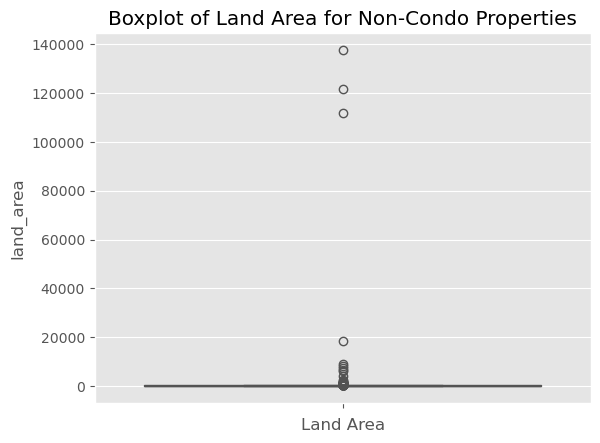

In [14]:
# Check outliers
sns.boxplot(data=train_df[train_df['property_type'] != 'Condo']['land_area'])
plt.title('Boxplot of Land Area for Non-Condo Properties')
plt.xlabel('Land Area')
plt.show()

In [15]:
# Find the outlier of land_area
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_clean['land_area'].quantile(0.25)
Q3 = train_clean['land_area'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print (lower_bound)
print (upper_bound)

# Outlier Thresholds: Values below -118 or above 410 are considered outliers.

-118.0
410.0


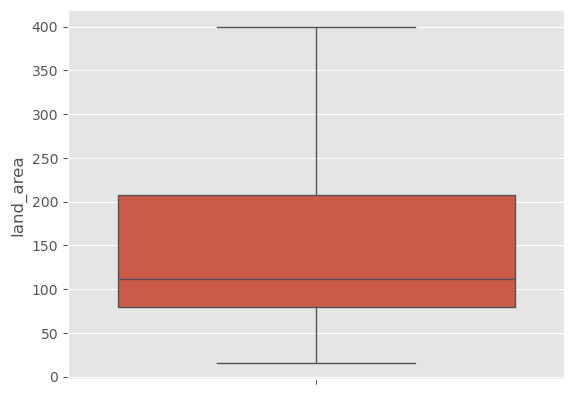

In [16]:
# Create the boxplot for 'land_area' where property_type is not 'Condo'
# Check logic. Filter excluding 'Condo' and set value of cutoff at 400 (The outlier is 410)
sns.boxplot(train_df[~((train_df['property_type'] != 'Condo') & (train_df['land_area'] > 400))]['land_area'])
plt.show()

In [17]:
# Drop value that are outlier
# Still exclude 'Condo'
train_clean = train_clean[~((train_clean['property_type'] != 'Condo') & (train_clean['land_area'] > 400))]

# Check work 
# Out put show 0 'property_type that not condo' that have land_are >= in the datasets
train_clean[(train_clean['property_type'] != 'Condo') & (train_clean['land_area'] > 400)] 

,id,province,district,subdistrict,address,property_type,total_units,bedrooms,baths,floor_area,...,longitude,nearby_stations,nearby_station_distance,nearby_bus_stops,nearby_supermarkets,nearby_shops,year_built,month_built,facilities,price


In [18]:
# Prepare to impute by calculating mean of each different property_type
# The reason is because the nature size of each property_type is different
# That's why we shouldn't use the same mean to all type

# Calculate mean land_area for Detached House
mean_detached_house_area = train_clean.loc[train_clean['property_type'] == 'Detached House', 'land_area'].mean()

# Calculate mean land_area for Townhouse
mean_townhouse_area = train_clean.loc[train_clean['property_type'] == 'Townhouse', 'land_area'].mean()

# Calculate mean floor_area for Condo
mean_condo_area = train_clean.loc[train_clean['property_type'] == 'Condo', 'floor_area'].mean()

# Display results
print("Mean Detached House Land Area:", mean_detached_house_area)
print("Mean Townhouse Land Area:", mean_townhouse_area)
print("Mean Condo Floor Area:", mean_condo_area)

Mean Detached House Land Area: 219.61207323107374
Mean Townhouse Land Area: 92.5907294286741
Mean Condo Floor Area: 39.43428199000652


In [19]:
# Fill 0 to all land_area missing data in property type == 'Condo'
train_clean.loc[train_clean['property_type'] == 'Condo', 'land_area'] = train_clean.loc[train_clean['property_type'] == 'Condo', 'land_area'].fillna(0)

In [20]:
# Fill NaN values in land_area with mean_townhouse_area only for rows where property_type is 'Townhouse'
train_clean.loc[train_clean['property_type'] == 'Townhouse', 'land_area'] = train_clean.loc[train_clean['property_type'] == 'Townhouse', 'land_area'].fillna(mean_townhouse_area)

# Fill NaN values in land_area with mean_detached_house_area only for rows where property_type is 'Detached House'
train_clean.loc[train_clean['property_type'] == 'Detached House', 'land_area'] = train_clean.loc[train_clean['property_type'] == 'Detached House', 'land_area'].fillna(mean_detached_house_area)

In [21]:
# Check missing value by each property_type again
train_clean[train_clean['land_area'].isna()]['property_type'].value_counts()

Series([], Name: count, dtype: int64)

In [22]:
# Drop the row that has empty value. 
# The number of rows with NaN is small no need to impute ['subdistrict','bedrooms', 'baths']
train_clean.dropna(subset=['subdistrict', 'bedrooms', 'baths'], inplace=True)

# Check work again
train_clean[['subdistrict', 'bedrooms', 'baths']].isnull().sum() 

subdistrict    0
bedrooms       0
baths          0
dtype: int64

In [23]:
# check Skewness to find which strategy is good for missing value handling
train_clean.skew(numeric_only=True)

id                    -4.767949
total_units            1.640908
bedrooms               1.081894
baths                  1.489241
floor_area             1.972143
floor_level            1.077876
land_area              1.685977
latitude               0.028708
longitude              0.052859
nearby_stations        0.629816
nearby_bus_stops      -0.650573
nearby_supermarkets    0.535075
nearby_shops           0.229385
year_built            -0.932438
price                  0.704767
dtype: float64

In [24]:
# Skewness of nearby_bus_stops: -0.6505732660375729
# Use Median: Similar to right-skewed distributions, using the median can help avoid the influence of outliers.
train_clean['nearby_bus_stops'] = train_clean['nearby_bus_stops'].fillna(train_clean['nearby_bus_stops'].median())

In [25]:
from sklearn.impute import KNNImputer, SimpleImputer
# Initialize the KNNImputer
# Hight to moderate positive skew should impute with KNNImputer
imputer = KNNImputer(n_neighbors=5) # Default 5

# Fit the imputer and transform the specified columns to handle missing values
train_clean[['total_units', 'floor_level']] = imputer.fit_transform(train_clean[['total_units', 'floor_level']])

In [26]:
# Why month missing when year_built is 0 missing value
# Skewness of year_built: -0.9494788902171235 Indicates that newer properties are more common, with fewer older properties.
# Check year_built
train_clean['year_built'].value_counts()

year_built
0       4072
2013    1091
2017     979
2015     937
2012     903
2014     896
2018     832
2016     820
2019     779
2020     623
2011     391
2009     378
2010     368
2022     188
2021     187
2007     168
2008     143
2023      67
2006      65
2004      38
2005      31
1993      23
1994      20
2002      18
2003      17
1998      13
1996      13
1997      11
1999      10
1995       9
1992       5
2000       3
2001       3
1991       1
1988       1
Name: count, dtype: int64

In [27]:
# Fill median to replace 'year_built' == 0
train_clean['year_built'] = train_clean['year_built'].replace(0, int(train_clean['year_built'].median()))

In [28]:
# Drop month_built a we look as a year
train_clean.drop(columns='month_built', inplace=True)

In [29]:
# Drop 'nearby_supermarkets' as it may be 0 nearby_supermarkets
train_clean['nearby_supermarkets'] = train_clean['nearby_supermarkets'].fillna(0)

# Dummy Variables


In [31]:
# Dummy the station
dummy_station = pd.get_dummies(
    train_clean['nearby_station_distance'].explode().apply(lambda x: pd.Series(x))[0],
    prefix='station_name'
).groupby(level=0).sum()

# Drop the specific column from dummy_station
dummy_station = dummy_station.drop(columns='station_name_E9 On Nut BTS')  # The most frequency happend to be near by station

# Join the dummy variables back to train_clean
train_clean = train_clean.join(dummy_station)

# Drop nearby_station_distance as we don't need anymore
train_clean.drop(columns='nearby_station_distance', inplace=True)

train_clean.columns #Check work

Index(['id', 'province', 'district', 'subdistrict', 'address', 'property_type',
       'total_units', 'bedrooms', 'baths', 'floor_area',
       ...
       'station_name_S12 Bang Wa BTS', 'station_name_S2 Sala Daeng BTS',
       'station_name_S3 Chong Nonsi BTS', 'station_name_S4 Saint Louis BTS',
       'station_name_S5 Surasak BTS', 'station_name_S6 Saphan Taksin BTS',
       'station_name_S7 Krung Thon Buri BTS',
       'station_name_S8 Wongwian Yai BTS', 'station_name_S9 Pho Nimit BTS',
       'station_name_W1 National Stadium BTS'],
      dtype='object', length=160)

In [32]:
# We already did for station_nearby name dummy_station
# Now will do for property_type & province

# Create dummy variables for province and property_type
# Bangkok is a baseline/Use drop_first = True as I want to drop Bangkok (B comes first before other province)
dummy_province = pd.get_dummies(train_clean['province'], drop_first=True).astype(int)

# Condo is a baseline/Use drop_first = True as I want to drop Condo (C comes first before other propery_type)
dummy_property_type = pd.get_dummies(train_clean['property_type'], drop_first=True).astype(int)  

# Concatenate the dummy variables to the original DataFrame
train_clean = pd.concat([train_clean, dummy_property_type, dummy_province], axis=1)


In [33]:
# Check the results
print(dummy_province.sample(n=5, random_state=42))  # Check sample from dummy_province
print(dummy_property_type.sample(n=5, random_state=42))  # Check sample from dummy_property_type

      Nonthaburi  Samut Prakan
815            0             0
8825           0             0
712            0             0
1221           0             0
1093           1             0
      Detached House  Townhouse
815                0          0
8825               0          0
712                0          0
1221               0          0
1093               0          1


In [34]:
# Convert facilities column to facilities count/ the more facilities may related to the price
train_clean['facilities'] = train_clean['facilities'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [35]:
# Check missing null again
print(train_clean.dtypes.to_frame(name='Data Type').join(train_clean.isna().sum().rename('Null Count')))

                                     Data Type  Null Count
id                                       int64           0
province                                object           0
district                                object           0
subdistrict                             object           0
address                                 object           0
...                                        ...         ...
station_name_W1 National Stadium BTS     int64           0
Detached House                           int64           0
Townhouse                                int64           0
Nonthaburi                               int64           0
Samut Prakan                             int64           0

[164 rows x 2 columns]


In [36]:
train_clean.shape

(14103, 164)

In [37]:
train_clean.to_csv('../datasets/train_clean.csv', index=False) 

# Prepare the test_df for prediction

In [39]:
# Fill 0 to all land_area missing data in property type == 'Condo'
test_df.loc[test_df['property_type'] == 'Condo', 'land_area'] = test_df.loc[test_df['property_type'] == 'Condo', 'land_area'].fillna(0)

# Fill NaN values in land_area with mean_townhouse_area only for rows where property_type is 'Townhouse'
test_df.loc[test_df['property_type'] == 'Townhouse', 'land_area'] = test_df.loc[test_df['property_type'] == 'Townhouse', 'land_area'].fillna(mean_townhouse_area)

# Fill NaN values in land_area with mean_detached_house_area only for rows where property_type is 'Detached House'
test_df.loc[test_df['property_type'] == 'Detached House', 'land_area'] = test_df.loc[test_df['property_type'] == 'Detached House', 'land_area'].fillna(mean_detached_house_area)

# Impute nearby_bus_stops
test_df['nearby_bus_stops'] = test_df['nearby_bus_stops'].fillna(test_df['nearby_bus_stops'].median())

# Hight to moderate positive skew should impute with KNNImputer
imputer = KNNImputer(n_neighbors=5) # Default 5

# Fit the imputer and transform the specified columns to handle missing values
test_df[['total_units', 'floor_level']] = imputer.fit_transform(test_df[['total_units', 'floor_level']])

# Fill median to replace 'year_built' == 0
test_df['year_built'] = test_df['year_built'].replace(0, int(test_df['year_built'].median()))

# Drop month_built a we look as a year
test_df.drop(columns='month_built', inplace=True)

# Drop 'nearby_supermarkets' as it may be 0 nearby_supermarkets
test_df['nearby_supermarkets'] = test_df['nearby_supermarkets'].fillna(0)

# Dummy the station
dummy_station_test = pd.get_dummies(
    test_df['nearby_station_distance'].explode().apply(lambda x: pd.Series(x))[0],
    prefix='station_name'
).groupby(level=0).sum()

# Drop the specific column from dummy_station
dummy_station_test = dummy_station_test.drop(columns='station_name_E9 On Nut BTS') # run later when finish EDA

# Join the dummy variables back to test_df
test_df = test_df.join(dummy_station_test)

# Drop nearby_station_distance as we don't need anymore
test_df.drop(columns='nearby_station_distance', inplace=True)
# We already did for station_nearby name dummy_station
# Now will do for property_type & province

# Create dummy variables for province 
dummy_province = pd.get_dummies(test_df['province'], drop_first=True).astype(int)

# Dummy property_type
dummy_property_type = pd.get_dummies(test_df['property_type'], drop_first=True).astype(int)  

# Concatenate the dummy variables to the original DataFrame
test_df = pd.concat([test_df, dummy_property_type, dummy_province], axis=1)

# Convert facilities column to facilities count/ the more facilities may related to the price
test_df['facilities'] = test_df['facilities'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [40]:
# Check why there is not the same column shape
train_columns = set(train_clean.columns)
test_columns = set(test_df.columns)

# Columns in train but not in test
train_not_in_test = train_columns - test_columns

# Columns in test but not in train
test_not_in_train = test_columns - train_columns

print(
    "Items in the training set but not in the test set:\n"
    f"{train_not_in_test}\n\n"
    "Items in the test set but not in the training set:\n"
    f"{test_not_in_train}"
)


Items in the training set but not in the test set:
{'station_name_BL32 Itsaraphap MRT', 'station_name_E23 Kheha Samut Prakan BTS', 'price', 'station_name_RN08 SRT Don Muang', 'station_name_BL02 Charan 13 MRT', 'station_name_B9 Rama IX Bridge BRT', 'station_name_N24 Khu Khot BTS'}

Items in the test set but not in the training set:
set()


In [41]:
# Add columns from train_not_in_test to test_df, except 'price'
# Fill in 0 (the test_df doesn't have those columns)
for column in train_not_in_test:
    if column != 'price':  # Check if the column is not 'price'
        test_df[column] = 0  # Add each column with all values set to 0

In [42]:
train_not_in_test

{'price',
 'station_name_B9 Rama IX Bridge BRT',
 'station_name_BL02 Charan 13 MRT',
 'station_name_BL32 Itsaraphap MRT',
 'station_name_E23 Kheha Samut Prakan BTS',
 'station_name_N24 Khu Khot BTS',
 'station_name_RN08 SRT Don Muang'}

In [43]:
train_clean.shape

(14103, 164)

In [44]:
test_df.shape

(2500, 163)

In [45]:
test_df.to_csv('../datasets/test_imputed.csv', index=False)